In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('games.csv')

In [ ]:
df.describe(include='object').drop(columns= 'increment_code')

In [ ]:
df.drop(columns='moves').head()

In [ ]:
df.dtypes

In [ ]:
'''
Esse trecho de código transforma a coluna de tempo que nesse dataset está 
em 'unix' para 'datatime' e também importa para CSV o resultado.
'''

df_times = df[['id', 'created_at', 'last_move_at']].copy()

df_times['created_at_dt'] = pd.to_datetime(df_times['created_at']/1000, unit='s', origin='unix')

df_times['last_move_at_dt'] = pd.to_datetime(df_times['last_move_at']/1000, unit='s', origin='unix')

df_result = pd.merge(df, df_times[['id', 'created_at_dt', 'last_move_at_dt']], on='id')

df_result.to_csv('game_completo.csv', index=False)

#df_result

In [ ]:
'''
Esse código nos mostra qual a abertura mais praticada.


## Queria entender porque dessa forma não funciona. ##
vv                                                  vv
mpo = df[['opening_eco']].groupby(by='opening_eco').agg('count').reset_index().head(10)
mpo = mpo.rename(columns={'id': 'count'})
mpo

'''

most_played_openings = (
                        df.drop(columns=['rated', 'created_at', 
                        'last_move_at', 'turns', 'victory_status',
                        'winner', 'increment_code', 'white_id', 'white_rating',
                        'black_id', 'black_rating', 'moves', 'opening_name', 'opening_ply'])
                        .groupby(by='opening_eco')
                        .agg('count')
                        .reset_index()
                        .rename(columns={'id': 'count', 'opening_eco': 'abertura'})
                        .sort_values(by='count', ascending=False)
                        .reset_index(drop=True)
                        )

# Rank das 10 aberturas mais praticadas.
rank_abertura_pop = most_played_openings.sort_values(by='count', ascending=False).reset_index(drop=True).head(10)
print(f'Rank das 10 aberturas mais praticadas:\n{rank_abertura_pop}')

plt.bar(rank_abertura_pop['abertura'], height=rank_abertura_pop['count'])

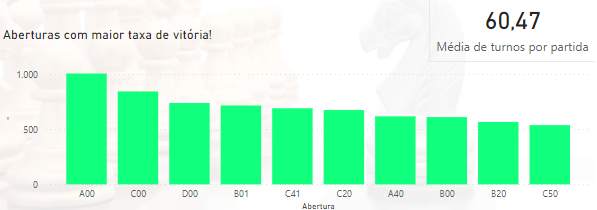

In [ ]:
# Número de partidas por usuário (peças brancas e pretas)

'''
#Verificando o número de partidas por usuário
partidas_jogadas_white = df['white_id'].value_counts()
partidas_jogadas_black = df['black_id'].value_counts()

# Verificando o número de partidas por usuário 'white'
partidas_jogadas_white = df['white_id'].value_counts()

# Verificando o número de partidas por usuário 'black'
partidas_jogadas_black = df['black_id'].value_counts()

# Somando as colunas
partidas_jogadas = partidas_jogadas_white.add(partidas_jogadas_black, fill_value=0).sort_values(ascending=False)  

# Uma mascara foi posta nos dados para minimizar as partidas que são jogadas por bots.
m3 = partidas_jogadas >=3
pj = partidas_jogadas[m3].head(20)

pj
# V1 do código abaixo
'''

partidas_jogadas_white = df.drop(columns=['rated', 'created_at', 
                                        'last_move_at', 'victory_status',
                                        'increment_code', 'id', 'winner', 'turns', 'opening_eco',
                                        'black_id', 'black_rating', 'moves', 'opening_name', 'opening_ply'])

partidas_jogadas_black = df.drop(columns=['rated', 'created_at', 
                                        'last_move_at', 'victory_status',
                                        'increment_code', 'id', 'winner', 'turns', 'opening_eco',
                                        'white_id', 'white_rating', 'moves', 'opening_name', 'opening_ply'])

partidas_jogadas_black = partidas_jogadas_black.rename(columns={'black_id': 'nickname', 'black_rating': 'rating'})
partidas_jogadas_white = partidas_jogadas_white.rename(columns={'white_id': 'nickname', 'white_rating': 'rating'})

b_w = pd.concat([partidas_jogadas_white, partidas_jogadas_black], ignore_index=True)
b_w['qnt_partidas'] = b_w.groupby('nickname')['nickname'].transform('count')
b_w.sort_values(by='qnt_partidas', ascending=False)

# Fazendo a média do 'rating' do jogador.
b_w['rating'] = b_w.groupby('nickname')['rating'].transform('mean').astype(int)

# Removendo duplicatas
b_w = b_w.drop_duplicates(subset='nickname')

# Ordenando o DataFrame pela coluna 'qnt_partidas' em ordem decrescente
b_w_ordenado = b_w.sort_values(by='qnt_partidas', ascending=False).reset_index(drop=True)

# Uma mascara foi posta nos dados para minimizar as partidas que são jogadas por bots.
m4 = b_w_ordenado['qnt_partidas'] >= 3
b_w_ordenado[m4] 

# Rank das 10 pessoas com mais partidas.
x = b_w_ordenado.head(10)
print(f'Rank das 10 pessoas com mais partidas:\n{x}\n')

# Rank das 10 pessoas com mais rating.
x = b_w_ordenado[m4].sort_values(by='rating', ascending=False).head(10).reset_index(drop=True)
print(f'Rank das 10 pessoas com mais rating:\n{x}')


In [ ]:
# Tentativa de vizualização dos dados em Gráfico. O nome fica embaralhado..
plt.bar(b_w_ordenado['nickname'].head(10), height= b_w_ordenado['qnt_partidas'].head(10))

In [ ]:
# Quantas partidas terminaram empatadas, por xeque mate, por tempo ou por desistência?]

df.groupby(['victory_status']).size()

In [ ]:
# Qual cor tem maior taxa de vitória por xeque mate, por tempo e por desistência?

num_vitoria = df.groupby(['victory_status', 'winner']).size()

print(f'Legenda:\n{num_vitoria}')

num_vitoria.unstack().plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribuição de Resultados por Estado de Vitória e Vencedor')
plt.xlabel('Tipo de Vitória')
plt.ylabel('Número de Jogos')
plt.show()

# Ainda existe uma parte de 'draw' em 'outoftime', mas isso ocorre por conta de uma regra do xadrez.

In [ ]:
# Qual a porcentagem de vitórias por cor?

x = df[['winner', 'victory_status']]

m5 = (x['victory_status'] != 'draw') & (x['winner'] != 'draw')

# Agrupando o resultado por 'winner'
percentagem = (x[m5]
                    .groupby('winner')['victory_status']
                    .value_counts(normalize=True)
                    .unstack()
                    .map(lambda x: f'{x*100:.2f}%')
                  )
numeral = x[m5].value_counts().unstack()

print(f'{numeral}\n')
print(percentagem)


A baixo podemos comparar os resultados com nossa análize em Bi do módulo passado.

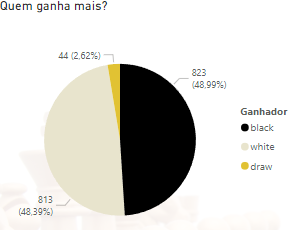

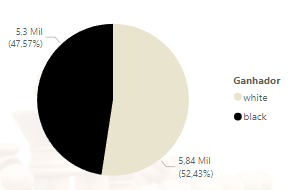

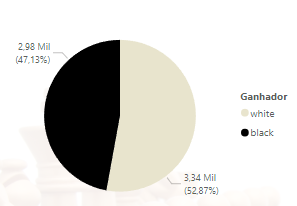

In [ ]:
sns.countplot(x='winner', data=df)
plt.title('Numero de Vitorias por Cor')
plt.show()